## Variational Autoencoder CoordConv filters

In [22]:
from keras.utils.vis_utils import plot_model
from keras_visualizer import visualizer
from keras.callbacks import EarlyStopping, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from autoencoders.VAE import VAECoordConv as VAE

DATASET_SIZE = 25084
INPUT_SHAPE = (40, 40, 1)

In [23]:
import tensorflow as tf

devices = tf.config.list_physical_devices('GPU')

if len(devices) < 1:
    raise Exception("Cannot initialize GPU")

print("GPU configured correctly")

GPU configured correctly


In [24]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3,
    horizontal_flip=True,
    vertical_flip=True
)
# Allow horizontal flip and vertical flip as a mirror image in both axes of a game is a valid game state

train_datagen = datagen.flow_from_directory(
    'images_trans/',
    target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
    color_mode='grayscale',
    class_mode='input',
    shuffle=True,
    subset='training'
)

val_datagen = datagen.flow_from_directory(
    'images_trans/',
    target_size=(INPUT_SHAPE[0], INPUT_SHAPE[1]),
    color_mode='grayscale',
    class_mode='input',
    shuffle=True,
    subset='validation'
)

Found 17559 images belonging to 1 classes.
Found 7524 images belonging to 1 classes.


Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_encoder (InputLayer)      [(None, 40, 40, 1)]  0                                            
__________________________________________________________________________________________________
coordinate_channel2d_6 (Coordin (None, 40, 40, 3)    0           input_encoder[0][0]              
__________________________________________________________________________________________________
conv1_enc (Conv2D)              (None, 40, 40, 16)   448         coordinate_channel2d_6[0][0]     
__________________________________________________________________________________________________
maxpool1 (MaxPooling2D)         (None, 20, 20, 16)   0           conv1_enc[0][0]                  
____________________________________________________________________________________________

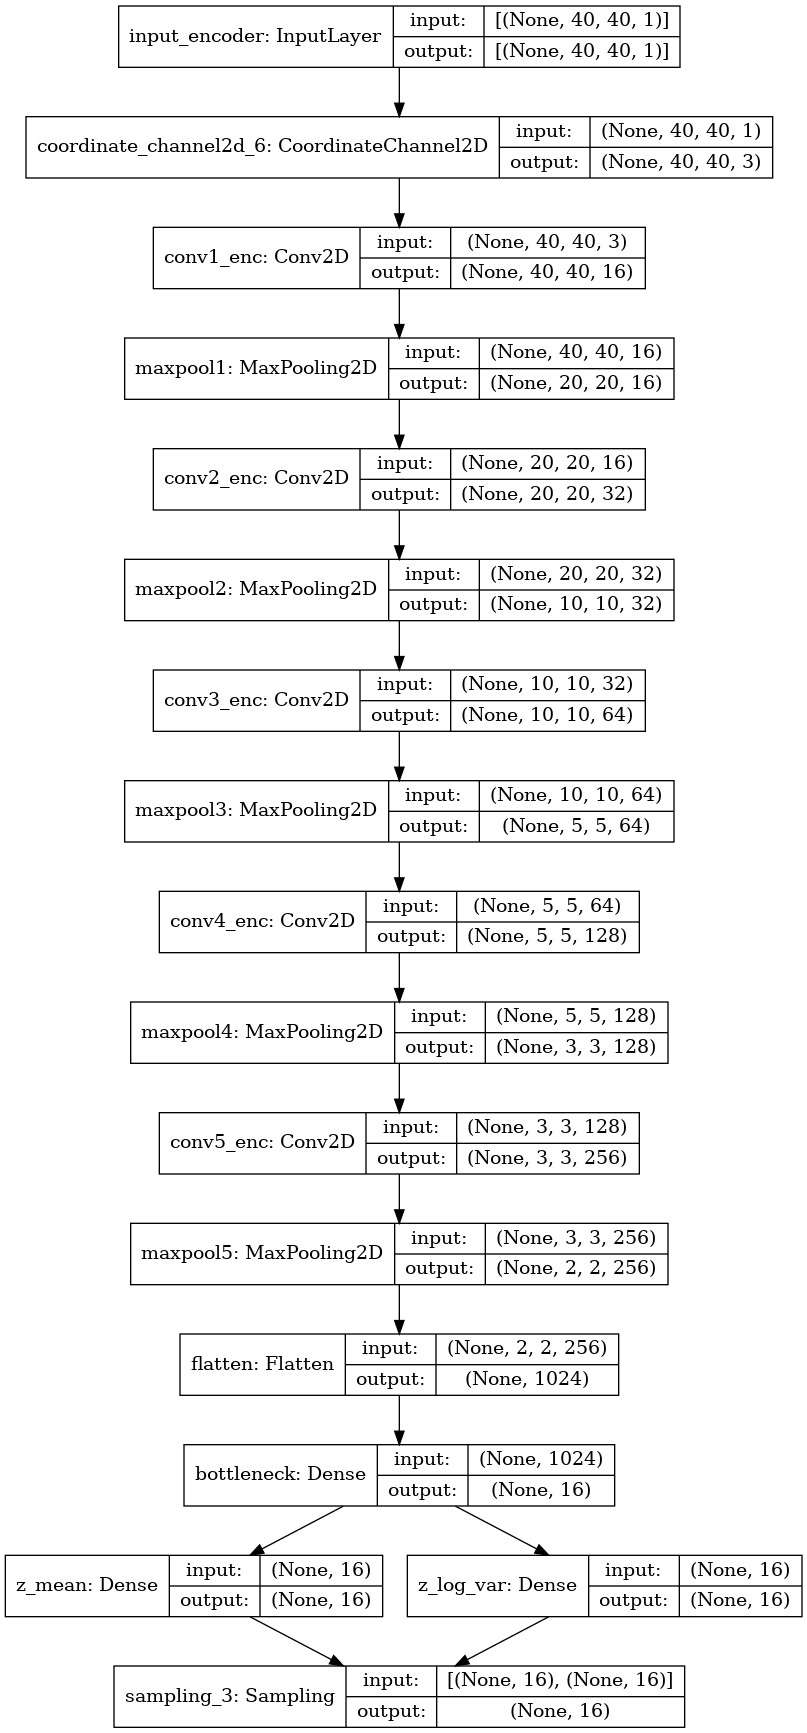

In [25]:
vae = VAE(
    layers=5,
    latent_size=16,
    kernel_size=3,
    input_shape=INPUT_SHAPE,
    filters=16,
    name="VAE"
)
vae.summary()

plot_model(vae.decoder, to_file='coord_dec.png', show_shapes=True)

In [26]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=40),
    TensorBoard(
        log_dir='./logs',
        histogram_freq=1
    )
]

history = vae.train(
    train_datagen, 
    val_datagen, 
    epochs=75, 
    callbacks=callbacks
)

Epoch 1/75
549/549 [==============================] - 12s 21ms/step - loss: 101.1535 - reconstruction_loss: 73.3764 - kl_loss: 1.0911 - val_loss: 58.7336 - val_reconstruction_loss: 53.6301 - val_kl_loss: 5.1034
Epoch 2/75
549/549 [==============================] - 10s 18ms/step - loss: 50.7476 - reconstruction_loss: 35.1170 - kl_loss: 7.7628 - val_loss: 38.6562 - val_reconstruction_loss: 27.9499 - val_kl_loss: 10.7064
Epoch 3/75
549/549 [==============================] - 11s 20ms/step - loss: 29.9096 - reconstruction_loss: 18.5380 - kl_loss: 9.8645 - val_loss: 23.8331 - val_reconstruction_loss: 14.2818 - val_kl_loss: 9.5513
Epoch 4/75
549/549 [==============================] - 11s 20ms/step - loss: 25.5655 - reconstruction_loss: 15.5130 - kl_loss: 9.8462 - val_loss: 22.5001 - val_reconstruction_loss: 12.9721 - val_kl_loss: 9.5280
Epoch 5/75
549/549 [==============================] - 11s 20ms/step - loss: 24.7170 - reconstruction_loss: 14.7004 - kl_loss: 9.9182 - val_loss: 20.8227 - val

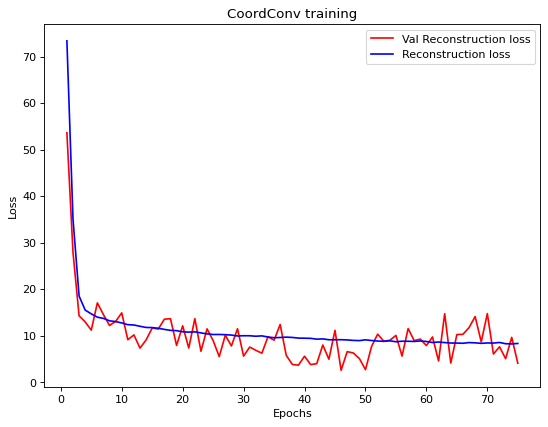

In [27]:
val_rec_loss = history.history['val_reconstruction_loss']
rec_loss = history.history['reconstruction_loss']

epochs = range(1, len(val_rec_loss) + 1)    

plt.figure(figsize=(8,6), dpi=80)
plt.plot(epochs, val_rec_loss, 'r', label='Val Reconstruction loss')
plt.plot(epochs, rec_loss, 'b', label='Reconstruction loss')
plt.title('CoordConv training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

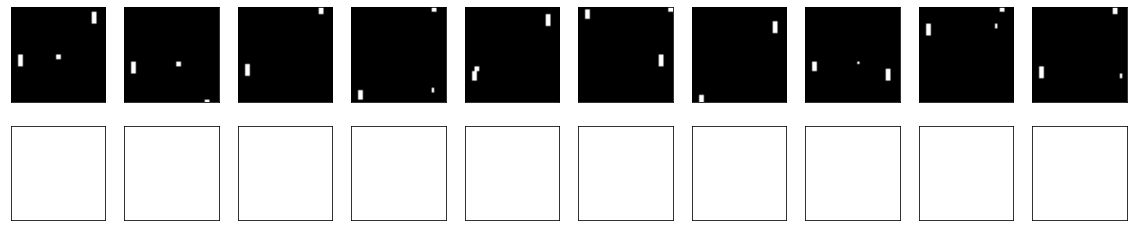

In [31]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import random

n = 10
images = np.empty((n, *INPUT_SHAPE))

for i in range(n):
    rand_img = random.randint(0, DATASET_SIZE)
    img = img_to_array(load_img(f"images_trans/pong_trans_{rand_img}.png", color_mode='grayscale'))
    images[i] = img

decoded_imgs = vae.predict(images)
latent = vae.encoder.predict(images)

#print(latent[:][2])

decoded_imgs = vae.decoder.predict(latent[:][2])

plt.figure(figsize=(20, 4))

for i in range(1, n+1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(images[i-1].reshape(INPUT_SHAPE[0], INPUT_SHAPE[1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i-1].reshape(INPUT_SHAPE[0], INPUT_SHAPE[1]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

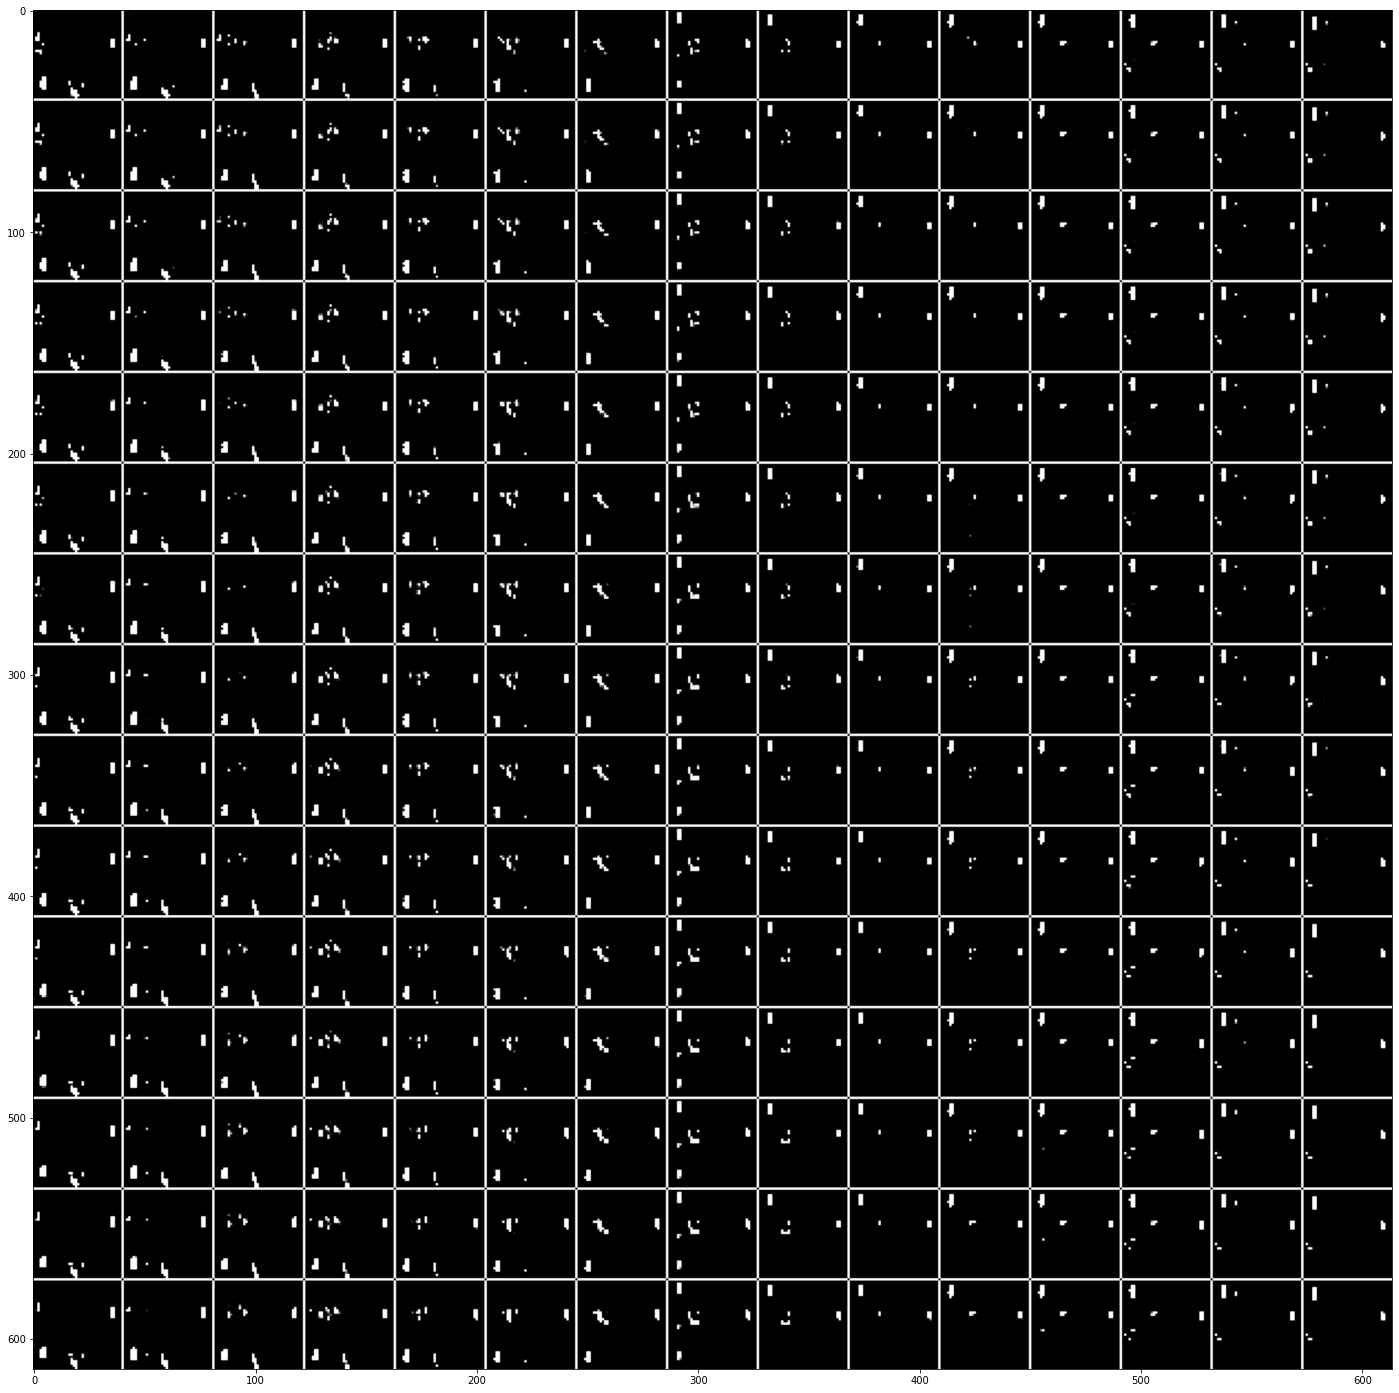

In [29]:
import random

def plot_latent_space(vae, n=15, figsize=25):
    # display a n*n 2D manifold of digits
    x_input_size = INPUT_SHAPE[0]
    y_input_size = INPUT_SHAPE[1]
    scale = 100.0
    figure = np.zeros((x_input_size * n + n - 1, y_input_size * n + n - 1))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            
            rest = rest = [i * 10 for i in range(-7, 7)]
            # missing =  -2.9679005e+00, -1.7151514e+01    
            z_sample = np.array([[xi, yi] + rest])
            #z_sample = np.array([[random.randint(-scale, scale) for i in range(16)]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(x_input_size, y_input_size)
            figure[
                i * x_input_size + i: (i + 1) * x_input_size + i,
                j * y_input_size + j: (j + 1) * y_input_size + j,
            ] = digit

            if i != len(grid_x) - 1:
                figure[
                    (i + 1) * x_input_size + i,
                    j * y_input_size + j: (j + 1) * y_input_size + j,
                ] = np.array([1] * y_input_size)
            if j != len(grid_y) - 1:
                figure[
                    i * x_input_size + i: (i + 1) * x_input_size + i,
                    (j + 1) * y_input_size + j,
                ] = np.array([1] * x_input_size)

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)